In [2]:
import mediapipe as mp
import cv2
import numpy as np
import os
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import matplotlib.pyplot as plt
import tensorflow as tf
import string

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

# images


In [2]:
image_ds = tf.keras.utils.image_dataset_from_directory("sibi", batch_size=32)
# image_ds = image_ds.map(lambda x, y: (x / 255.0, y))

Found 584 files belonging to 27 classes.


In [6]:
image_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [7]:
images, labels = image_ds.take(1).as_numpy_iterator().next()

In [44]:
def show(image, label):
  plt.figure()
  plt.imshow(image.numpy().astype(np.uint8))
  plt.title(string.ascii_uppercase[label.numpy()])
  # plt.title(label.numpy().decode('utf-8'))
  plt.axis('off')

In [19]:
image_ds.take(2)

<_TakeDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [37]:
# draw_landmarks_on_image
MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

In [14]:
# base_options = python.BaseOptions(model_asset_path='models/hand_landmarker.task')
# options = vision.HandLandmarkerOptions(base_options=base_options,
#                                        num_hands=2)
# detector = vision.HandLandmarker.create_from_options(options)

# STEP 3: Load the input image.
def detect(image_data: np.array):
    # image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_data)
    
    # detection_result = detector.detect(image)
    with mp_hands.Hands(
        model_complexity=0,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5) as hands:
    
        results = hands.process(image_data)
    
    # if results.multi_hand_landmarks:
    #     # img_array = image_data.copy()
    #     # for hand_landmarks in results.multi_hand_landmarks:
    #     #         mp_drawing.draw_landmarks(
    #     #         img_array,
    #     #         hand_landmarks,
    #     #         mp_hands.HAND_CONNECTIONS,
    #     #         mp_drawing_styles.get_default_hand_landmarks_style(),
    #     #         mp_drawing_styles.get_default_hand_connections_style())
    #     # annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
    #     # _, jpg  = cv2.imencode(".jpg", cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
    #     # display(Image(jpg))
    #     return results, img_array
    return results

In [15]:
@tf.py_function(Tout=tf.float32)
def random_augment(image):
    image = tf.keras.layers.RandomRotation(0.2)(image)
    image = tf.keras.layers.RandomZoom(0.2)(image)
    image = tf.keras.layers.RandomTranslation(0.1, 0.1)(image)
    return image

def augment_image(image, label):
    im_shape = image.shape
    image = random_augment(image)
    image.set_shape(im_shape)
    label.set_shape(label.shape)
    return image, label

In [16]:
augmented_ds = image_ds.map(augment_image)
augmented_ds.element_spec

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

32


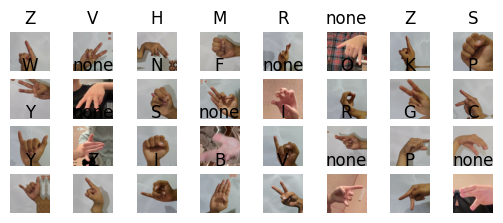

In [27]:
for images, labels in augmented_ds.take(1):
    print(images.shape[0])
    for i in range(images.shape[0]):
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title((list(string.ascii_uppercase) + ["none"])[labels[i].numpy()])
        plt.axis("off")

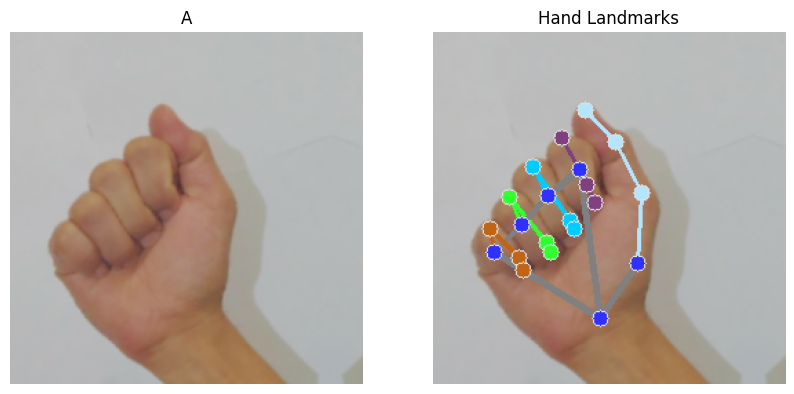

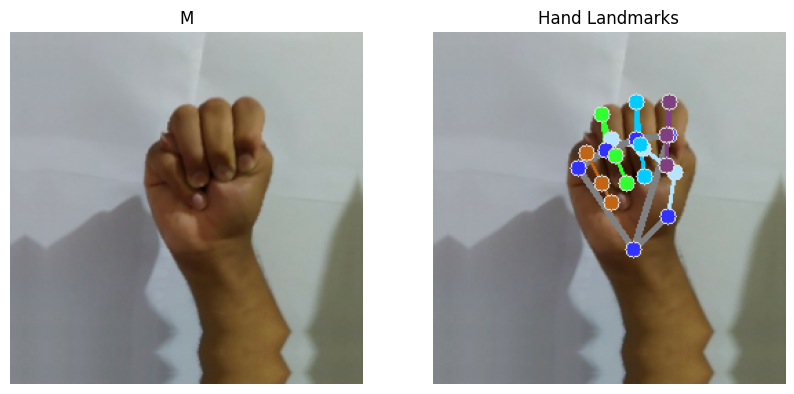

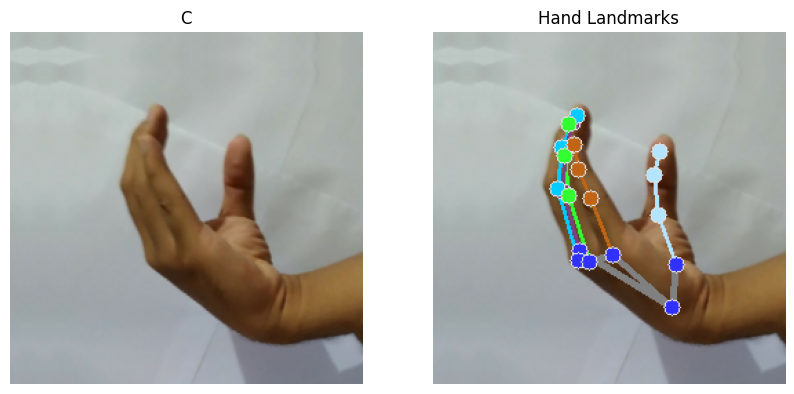

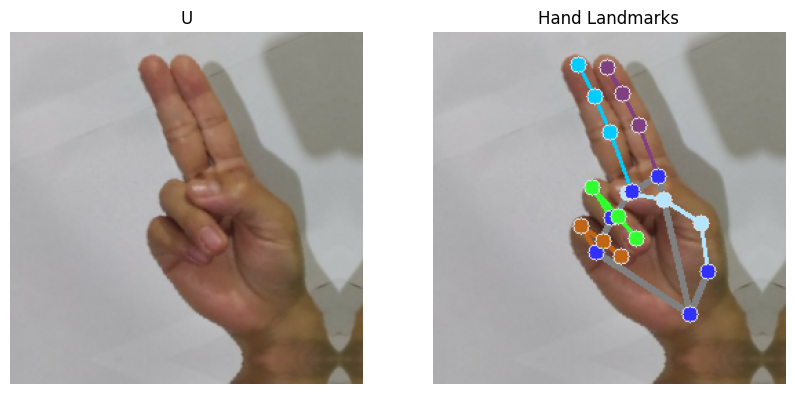

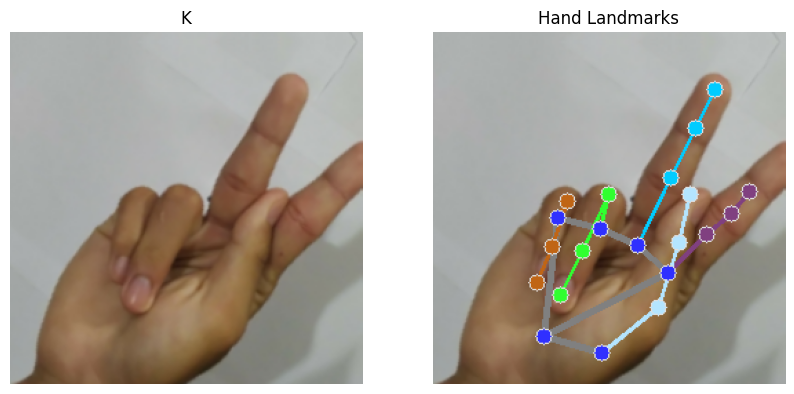

In [15]:
for img, label in augmented_ds.take(5):
    img = img.numpy().astype(np.uint8)
    res, annotated_image = detect(img)
    # make subplots for 2 images horizontally
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    # fig.title(string.ascii_uppercase[label.numpy()])
    axs[0].imshow(img)
    axs[0].axis('off')
    axs[0].set_title((string.ascii_uppercase+' ')[label.numpy()])
    axs[1].imshow(annotated_image)
    axs[1].axis('off')
    axs[1].set_title("Hand Landmarks")
    plt.show()

In [269]:
landmark_ds = augmented_ds.map(img_to_landmark)

In [270]:
landmark_ds.element_spec

(TensorSpec(shape=(127,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [181]:
for landmarks, label in landmark_ds.take(1):
    print(landmarks)
    print(label)

tf.Tensor(
[ 0.00000000e+00  9.74241138e-01  6.81503057e-01 -4.56245658e-07
  9.22671020e-01  6.62193656e-01 -2.10882217e-01  7.52718806e-01
  6.59244239e-01 -2.57080585e-01  5.94610274e-01  7.00867653e-01
 -2.59325981e-01  4.57708985e-01  7.44495690e-01 -2.58104652e-01
  5.93708396e-01  5.72983027e-01 -1.66910827e-01  3.90223742e-01
  6.40025139e-01 -2.20680952e-01  2.61394978e-01  6.90422237e-01
 -2.55961597e-01  1.56106472e-01  7.25065708e-01 -2.78409958e-01
  5.92829585e-01  6.47941768e-01 -8.24814811e-02  4.62632358e-01
  8.22057128e-01 -1.66781753e-01  4.35305834e-01  9.53963876e-01
 -2.18361869e-01  4.29669619e-01  1.05209398e+00 -2.32015684e-01
  6.18424058e-01  7.18975306e-01 -1.53928939e-02  5.84670067e-01
  8.60611916e-01 -1.39038652e-01  7.26577520e-01  8.98269176e-01
 -1.89713821e-01  8.21981311e-01  8.95730317e-01 -1.85963839e-01
  6.58922374e-01  7.66202927e-01  3.90727855e-02  6.46827638e-01
  8.70483398e-01 -8.24131519e-02  7.50964582e-01  8.91011059e-01
 -1.21254422e-

In [211]:
x = landmark_ds.take(1).as_numpy_iterator().next()
pred = model(np.expand_dims(x[0], 0))
np.argmax(pred.numpy()), x[1]

(9, 9)

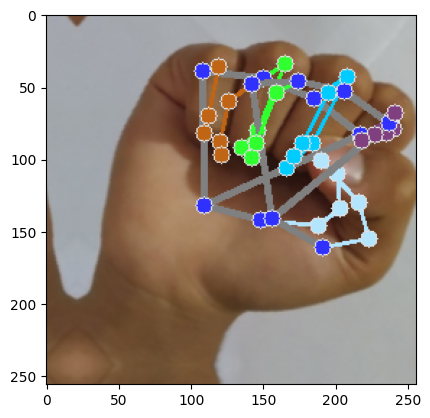

In [21]:
img_arr = tf.keras.preprocessing.image.load_img("sibi\S\S_03.jpg", target_size=(256, 256))
img_arr = tf.keras.preprocessing.image.img_to_array(img_arr).astype(np.uint8)
img_arr = random_augment(img_arr).numpy().astype(np.uint8)
res, annotated_image = detect(img_arr, view=True)
plt.imshow(annotated_image)

In [8]:
def landmark_dataset_generator(
        directory: os.PathLike,
        batch_size: int = 32,
        image_size: tuple[int, int] = (256, 256),
        shuffle: bool = True,
        seed: int = 42,
        label_mode: str = 'int',
        validation_split: float = None,
        # augmentation parameters
        rotation_range: float = 0,
        zoom_range: float = 0,
        width_shift_range: float = 0,
        height_shift_range: float = 0,
):
    # IMAGE DATASET
    image_ds = tf.keras.utils.image_dataset_from_directory(
        directory,
        batch_size=None,
        image_size=image_size,
        shuffle=shuffle,
        seed=seed,
        label_mode=label_mode,
        validation_split=validation_split,
        subset="both" if validation_split is not None else None
    )

    # get the index of the unknown class
    if validation_split is not None:
        unknown_class_index = image_ds[0].class_names.index("none")
    else:
        unknown_class_index = image_ds.class_names.index

    # AUGMENTATION FUNCTIONS
    @tf.py_function(Tout=tf.float32)
    def random_augment(image):
        image = tf.keras.layers.RandomRotation(rotation_range)(image)
        image = tf.keras.layers.RandomZoom(zoom_range)(image)
        image = tf.keras.layers.RandomTranslation(height_shift_range, width_shift_range)(image)
        return image

    # AUGMENTATION PIPELINE
    def augment_image(image, label):
        im_shape = image.shape
        image = random_augment(image)
        image.set_shape(im_shape)
        label.set_shape(())
        return image, label
    
    # LANDMARK EXTRACTION FUNCTION
    @tf.py_function(Tout=[tf.float32, tf.int32])
    def get_landmark(image, label):
        landmarks_list = []
        with mp_hands.Hands(model_complexity=0,
                            min_detection_confidence=0.5,
                            min_tracking_confidence=0.5) as hands:
    
            result = hands.process(image.numpy().astype(np.uint8))

        try:
            landmarks_list.append(result.multi_handedness[0].classification[0].index)
        except (IndexError, TypeError):
            # undetectable hand
            return np.zeros(127, dtype=np.float32), unknown_class_index

        hl_wl = list(result.multi_hand_landmarks[0].landmark) + list(result.multi_hand_world_landmarks[0].landmark)
        # for landmark in result.hand_landmarks[0] + result.hand_world_landmarks[0]:
        for landmark in hl_wl:
            landmarks_list.extend([landmark.x, landmark.y, landmark.z])
        
        landmarks_array = np.array(landmarks_list, dtype=np.float32)
        return landmarks_array, label

    # LANDMARK EXTRACTION PIPELINE
    def img_to_landmark(image, label):
        landmarks, label = get_landmark(image, label)
        landmarks.set_shape((127,))
        label.set_shape(())
        return landmarks, label

    # DATASET PIPELINE
    if validation_split is not None:
        train_ds = image_ds[0]
        val_ds = image_ds[1]
        # augment
        train_ds = train_ds.map(augment_image)
        # val_ds = val_ds.map(augment_image)
        # extract landmarks
        train_ds = train_ds.map(img_to_landmark)
        val_ds = val_ds.map(img_to_landmark)
        # batch and prefetch
        train_ds = train_ds.batch(batch_size)
        val_ds = val_ds.batch(batch_size)
        train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
        val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
        # set class names
        train_ds.class_names = image_ds[0].class_names
        val_ds.class_names = image_ds[0].class_names
        return train_ds , val_ds
    else:
        augmented_ds = image_ds.map(augment_image)
        landmark_ds = augmented_ds.map(img_to_landmark)
        # batch and prefetch
        landmark_ds = landmark_ds.batch(batch_size)
        landmark_ds = landmark_ds.prefetch(tf.data.AUTOTUNE)
        # set class names
        landmark_ds.class_names = image_ds.class_names

        return landmark_ds

In [9]:
landmark_ds = landmark_dataset_generator("sibi", 
                                         batch_size=32, 
                                         validation_split=0.2,
                                         rotation_range=0.2, 
                                         zoom_range=0.2, 
                                         width_shift_range=0.1, 
                                         height_shift_range=0.1)
landmark_ds

Found 584 files belonging to 27 classes.
Using 468 files for training.
Using 116 files for validation.


(<_BatchDataset element_spec=(TensorSpec(shape=(None, 127), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 127), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [10]:
train_ds, val_ds = landmark_ds

In [12]:
x, y = train_ds.take(1).as_numpy_iterator().next()

In [8]:
a,b,c,d = 0,0,0,0

In [9]:
# check a b c d is not 0
any([a, b, c, d])

False

# videos

In [15]:
cap = cv2.VideoCapture("video\Adik.webm")

203.0

In [31]:
cap = cv2.VideoCapture("video\Adik.webm")
num_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
print(num_frames)
with mp_hands.Hands(
    model_complexity=0,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as hands:
    
    landmarks = []
    for i in range(int(num_frames)):
        ret, frame = cap.read()
        if ret:
            print(f"processing frame {i}: ", end='')
            landmark_list = []
            results = hands.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            if results.multi_hand_landmarks:
                landmark_list.append(results.multi_handedness[0].classification[0].index)
                hl_wl = list(results.multi_hand_landmarks[0].landmark) + list(results.multi_hand_world_landmarks[0].landmark)
                for landmark in hl_wl:
                    landmark_list.extend([landmark.x, landmark.y, landmark.z])
                print("OK", end='')
                arr = np.array(landmark_list)
            else:
                arr = np.zeros(127)
            print()
            landmarks.append(arr)



203.0
processing frame 0: 
processing frame 1: 
processing frame 2: 
processing frame 3: 
processing frame 4: 
processing frame 5: 
processing frame 6: 
processing frame 7: 
processing frame 8: 
processing frame 9: 
processing frame 10: 
processing frame 11: 
processing frame 12: 
processing frame 13: 
processing frame 14: 
processing frame 15: 
processing frame 16: 
processing frame 17: 
processing frame 18: 
processing frame 19: 
processing frame 20: 
processing frame 21: 
processing frame 22: 
processing frame 23: 
processing frame 24: 
processing frame 25: 
processing frame 26: 
processing frame 27: 
processing frame 28: 
processing frame 29: 
processing frame 30: 
processing frame 31: 
processing frame 32: 
processing frame 33: 
processing frame 34: 
processing frame 35: 
processing frame 36: 
processing frame 37: 
processing frame 38: 
processing frame 39: 
processing frame 40: OK
processing frame 41: OK
processing frame 42: OK
processing frame 43: OK
processing frame 44: OK
proc

In [32]:
landmarks = np.array(landmarks)
landmarks.shape

(203, 127)

In [34]:
landmarks

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

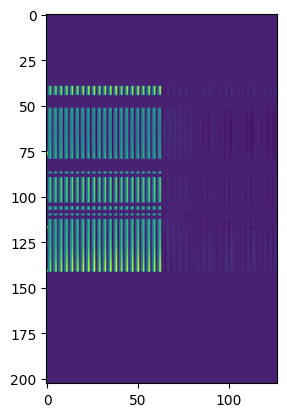

In [33]:
import matplotlib.pyplot as plt

plt.imshow(landmarks, cmap='viridis')